<a href="https://colab.research.google.com/github/hscrown/madatpublicdata/blob/main/SVD%EB%A5%BC_%EB%94%A5%EB%9F%AC%EB%8B%9D%EA%B3%BC_%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9C%EB%A1%9C_%EA%B5%AC%ED%98%84%ED%95%98%EA%B8%B0(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


# 데이터로드
df = pd.read_csv('user_rating_1000.csv')

# 평점이 0인 데이터 훈련데이터에서 제거
non_zero_df = df[df['rating'] != 0]

# 피봇테이블 만들기
pivot_table = non_zero_df.pivot(index='user_id', columns='place_id', values='rating').fillna(0)

# 훈련,테스트 데이터셋 분리
train, test = train_test_split(pivot_table, test_size=0.2, random_state=42)

# Flatten the matrix and create user-item pairs
train_users, train_items = np.where(train > 0)
train_ratings = train.values[train > 0]

test_users, test_items = np.where(test > 0)
test_ratings = test.values[test > 0]

# Model inputs
user_input = Input(shape=(1,), dtype='int32')
item_input = Input(shape=(1,), dtype='int32')

# Embeddings
user_embedding = Embedding(input_dim=pivot_table.shape[0], output_dim=15, input_length=1)(user_input)
item_embedding = Embedding(input_dim=pivot_table.shape[1], output_dim=15, input_length=1)(item_input)

# Flatten the embeddings
user_vector = Flatten()(user_embedding)
item_vector = Flatten()(item_embedding)

# Dot product of user and item embeddings
y_hat = Dot(axes=1)([user_vector, item_vector])

# Create and compile model
model = Model(inputs=[user_input, item_input], outputs=y_hat)
model.compile(optimizer='adamW', loss='mean_squared_error', metrics=[RootMeanSquaredError()])

# Model summary
model.summary()

# 얼리스타핑 설정
early_stopping = EarlyStopping(
    monitor='val_root_mean_squared_error',  # 모니터할 지표
    patience=5,  # 지정된 에포크 동안 개선되지 않으면 중단
    verbose=1,
    mode='min',  # 'min' 모니터링 지표가 감소하는 것을 개선으로 봄
    restore_best_weights=True  # 가장 좋은 모델의 가중치로 복원
)

# 모델 학습 (얼리스타핑 적용)
history = model.fit(
    [train_users, train_items], train_ratings,
    validation_data=([test_users, test_items], test_ratings),
    epochs=20,
    verbose=1,
    callbacks=[early_stopping]  # 콜백 리스트에 얼리스타핑 추가
)




Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_6 (Embedding)     (None, 1, 15)                15000     ['input_7[0][0]']             
                                                                                                  
 embedding_7 (Embedding)     (None, 1, 15)                24945     ['input_8[0][0]']             
                                                                                            

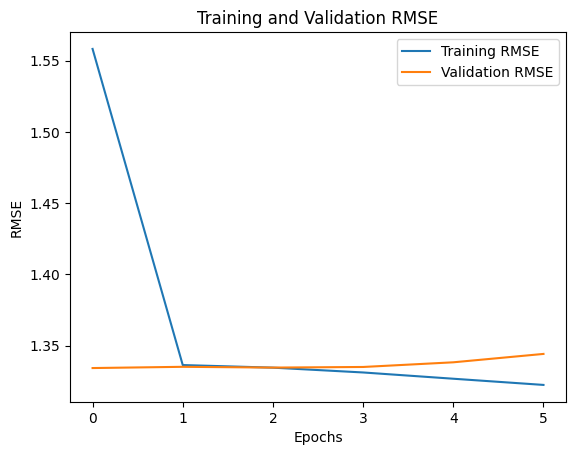

In [ ]:
# 시각화
plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.title('Training and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [ ]:
# 모델 저장
model.save('model0425_1959.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# user_id==11의 평점이 0인데이터, 그린까 아직 평점을 매기지 않은 장소 구하기
unrated_places = pivot_table.loc[11].loc[pivot_table.loc[11] == 0].index
from tensorflow.keras.models import load_model
# 모델 불러오기
model = load_model('model0425_1959.h5')

df2 = df.copy()

# 모델 예측
predictions = model.predict([df2['user_id'], df2['place_id']])

# 예측 평점 출력
print(predictions)

# df2에 'predict_rating' 컬럼추가하기
df2['predict_rating'] = predictions

51969/51969 [==============================] - 77s 1ms/step
[[3.3293538 ]
 [3.3794937 ]
 [3.485722  ]
 ...
 [0.02740761]
 [0.01810978]
 [0.02442015]]


In [ ]:
# user아이디가 11인 사람의 실제 평점과 예측평점
df2[df2['user_id'] == 11].sort_values(by='rating', ascending=False)

,user_id,rating,place_id,predict_rating
19109,11,5.0,816,3.217421
19255,11,5.0,962,3.410279
19592,11,5.0,1299,3.977800
18624,11,5.0,331,3.704397
18958,11,5.0,665,3.760380
...,...,...,...,...
19679,11,0.0,1386,3.406292
18554,11,0.0,261,3.425041
18923,11,0.0,630,3.466001
19838,11,0.0,1545,3.880843


In [ ]:
# user아이디가 11인 사람의 예측평점구하기
df2[df2['user_id'] == 11][df2['rating']== 0].sort_values(by='predict_rating', ascending=False).head(10)

<ipython-input-24-308c353ac7d3>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2[df2['user_id'] == 11][df2['rating']== 0].sort_values(by='predict_rating', ascending=False).head(10)


,user_id,rating,place_id,predict_rating
19631,11,0.0,1338,4.186043
19897,11,0.0,1604,4.087683
19040,11,0.0,747,3.881703
19838,11,0.0,1545,3.880843
18366,11,0.0,73,3.848138
19907,11,0.0,1614,3.793566
19125,11,0.0,832,3.781393
19258,11,0.0,965,3.762385
19168,11,0.0,875,3.762366
19709,11,0.0,1416,3.751060
